# Tool comparison

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------

# Read results of individual analysis

In [3]:
result_files = glob.glob("results/*")
result_files = [f for f in result_files if "merged_results.tsv" not in f]

In [4]:
rows = []
for f in result_files:
    
    base = os.path.splitext(os.path.basename(f))[0]
    elements = base.split("_")
    element_names = ["dataset", "tool", "replicates", "transform"]
    
    info = {}
    for i, element in enumerate(elements):
        info[element_names[i]] = element
    
    # Add p-value/props
    results = pd.read_csv(f, sep="\t")
    
    #Limit to one covariate if sccoda
    if "sccoda" in base:
        covariates = results["Covariate"].unique().tolist()
        results = results[results["Covariate"] == covariates[0]]
    
    for i, row in results.iterrows():
        info_row = info.copy()
        
        if "sccoda" in base:
            info_row["covariate"] = row.iloc[0]
            info_row["cluster"] = row.iloc[1]
            
            if "pct_credible_effect" in results.columns:
                info_row["credible_effect"] = row["pct_credible_effect"]
                info_row["significant"] = info_row["credible_effect"] > 50
            else:
                info_row["credible_effect"] = int(row.iloc[2]) * 100  # true -> 100
                info_row["significant"] = row.iloc[2]
            
            info_row["compare_value"] = info_row["credible_effect"]
            
        else:
            info_row["cluster"] = row.iloc[0]
            info_row["baseline_props"] = row.iloc[1] if "scanpro" in base else row.iloc[2]
            info_row["p-value"] = row.iloc[-2]
            info_row["FDR"] = row.iloc[-1]
            info_row["significant"] = info_row["FDR"] < 0.05

            info_row["compare_value"] = -np.log10(info_row["FDR"])
            if info_row["compare_value"] == np.inf:
                info_row["compare_value"] = 20

        rows.append(info_row)

/tmp/ipykernel_8303/4122897376.py:43: RuntimeWarning: divide by zero encountered in log10
  info_row["compare_value"] = -np.log10(info_row["FDR"])
/tmp/ipykernel_8303/4122897376.py:43: RuntimeWarning: divide by zero encountered in log10
  info_row["compare_value"] = -np.log10(info_row["FDR"])


In [5]:
results = pd.DataFrame(rows)

In [6]:
results

,dataset,tool,replicates,transform,cluster,baseline_props,p-value,FDR,significant,compare_value,covariate,credible_effect
0,covid,scanpro,norep,arcsin,B,0.003343,0.001976,0.097905,False,1.009196,NaN,NaN
1,covid,scanpro,norep,arcsin,Epithelial,0.053652,0.045517,0.124046,False,0.906419,NaN,NaN
2,covid,scanpro,norep,arcsin,Macrophages,0.750870,0.726995,0.000072,True,4.144060,NaN,NaN
3,covid,scanpro,norep,arcsin,Mast,0.001064,0.000593,0.653567,False,0.184710,NaN,NaN
4,covid,scanpro,norep,arcsin,NK,0.016425,0.015235,0.000664,True,3.178081,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
208,scatac,sccoda,rep,NaN,Schwann cells,NaN,NaN,NaN,False,0.000000,tissue[T.muscle],0.0
209,scatac,sccoda,rep,NaN,Skeletal muscle cells,NaN,NaN,NaN,True,100.000000,tissue[T.muscle],100.0
210,scatac,sccoda,rep,NaN,Smooth muscle cells,NaN,NaN,NaN,False,0.000000,tissue[T.muscle],0.0
211,scatac,sccoda,rep,NaN,Stromal cells,NaN,NaN,NaN,False,0.000000,tissue[T.muscle],0.0


In [7]:
results.to_csv("results/merged_results.tsv", sep="\t")

----------

# Compare results per dataset

In [8]:
datasets = ["pbmc", "heart", "scatac"]

In [9]:
results_compare = results.copy()
results_compare = results_compare[results_compare["transform"] != "arcsin"]
results_compare = results_compare[results_compare["dataset"].isin(datasets)]
results_compare["tool_rep"] = results_compare["tool"] + "_" + results_compare["replicates"]

In [10]:
plot_title = {"pbmc": "PBMC male vs. female", "heart": "Heart development", "scatac": "Fetal scATAC cell atlas"}

In [11]:
value_table = results_compare.pivot(columns="tool_rep", index=["dataset", "cluster"], values="compare_value")
value_table["propeller_norep"] = np.nan

In [12]:
annot_table = results_compare.pivot(columns="tool_rep", index=["dataset", "cluster"], values="significant")
annot_table.replace({True: "*", False: ""}, inplace=True)
annot_table["propeller_norep"] = "NA"

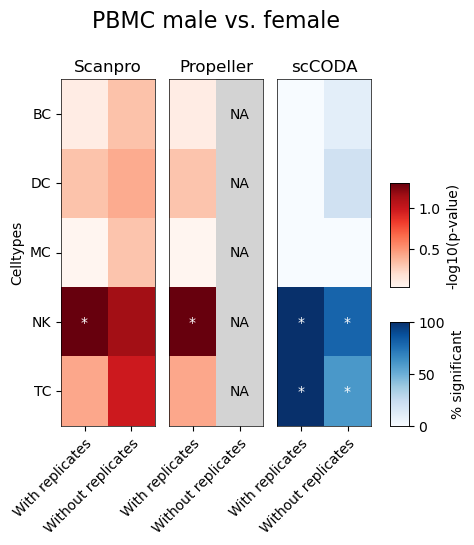

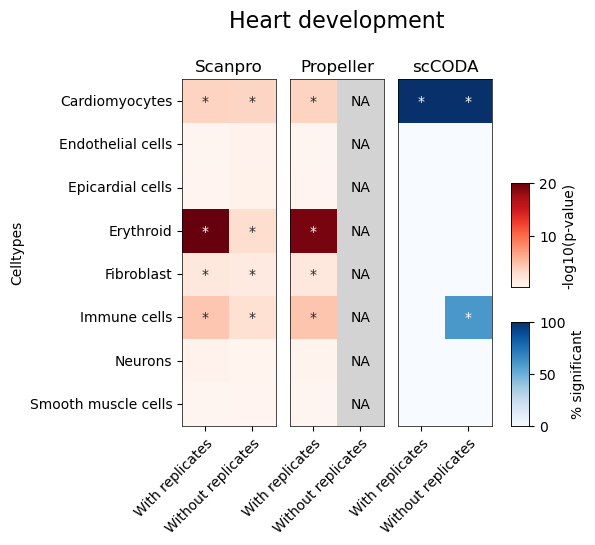

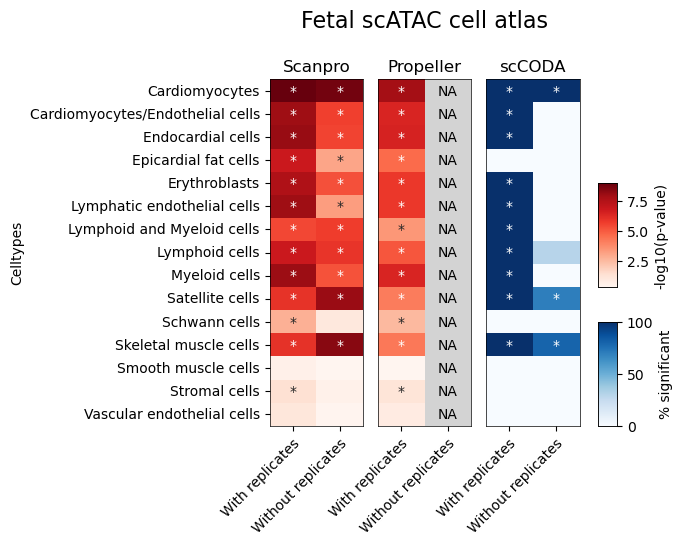

In [13]:
for dataset in datasets:
    
    values = value_table.query(f"dataset == '{dataset}'").reset_index(level=0, drop=True)
    annot = annot_table.query(f"dataset == '{dataset}'").reset_index(level=0, drop=True)
    
    fig, axarr = plt.subplots(1,3, figsize=(4, 4.5))
    plt.subplots_adjust(wspace=0.15)

    #Create extra axes for colorbars
    pvalue_cax = inset_axes(axarr[-1],
                            width="20%", height="30%",
                            loc='lower left',
                            bbox_to_anchor=(1.2, 0.4, 1, 1),
                            bbox_transform=axarr[-1].transAxes, borderpad=0)
    pvalue_cax.set_frame_on(True)
    
    percent_cax = inset_axes(axarr[-1],
                             width="20%", height="30%",
                             loc='lower left',
                             bbox_to_anchor=(1.2, 0, 1, 1),
                             bbox_transform=axarr[-1].transAxes, borderpad=0)
    percent_cax.set_frame_on(True)

    #Get max p-value to set for scanpro/propeller
    columns = ["scanpro_rep", "scanpro_norep", "propeller_rep"]
    max_value = values[columns].max().max()  
    
    ### Scanpro
    ax = axarr[0]
    sns.heatmap(values[["scanpro_rep", "scanpro_norep"]], 
                annot=annot[["scanpro_rep", "scanpro_norep"]], fmt='',
                ax=ax, cmap='Reds', vmax=max_value, cbar_ax=pvalue_cax, cbar_kws={"label": "-log10(p-value)"})
    ax.set_title("Scanpro")
    

    ### Propeller
    ax = axarr[1]

    # Plot NaN text
    nan_table = (annot[["propeller_rep", "propeller_norep"]] == "NA").replace({False: np.nan, True: 1})
    sns.heatmap(nan_table, ax=ax, cbar=False, annot=np.full_like(nan_table, "NA", dtype=object), fmt='', 
                alpha=0, annot_kws={"color":"black"})
    
    g = sns.heatmap(values[["propeller_rep", "propeller_norep"]],
                    annot=annot[["propeller_rep", "propeller_norep"]], fmt='',
                    ax=ax, yticklabels=False, cmap='Reds', cbar=False, vmax=max_value)
    g.set_facecolor('lightgrey')
    ax.set_title("Propeller")

    #### Sccoda
    ax = axarr[2]
    sns.heatmap(values[["sccoda_rep", "sccoda_norep"]], 
                annot=annot[["sccoda_rep", "sccoda_norep"]], fmt='',
                cmap="Blues",
                ax=ax, yticklabels=False, cbar_ax=percent_cax,
                cbar_kws={"label": "% significant"})
    ax.set_title("scCODA")
    
    percent_cax.set_frame_on(True)
    
    ### Set format of labels
    for ax in axarr:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
        ax.set_xticks(ax.get_xticks(), ["With replicates", "Without replicates"], rotation=45, ha='right', rotation_mode='anchor')
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        # Drawing the frame
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
    
    _ = axarr[0].set_ylabel("Celltypes")
    
    #Border around cbars
    for cax in [pvalue_cax, percent_cax]:
        for _, spine in cax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            
    # Set title of plot
    title = plot_title[dataset]
    axarr[1].text(0.5, 1.15, title, transform=axarr[1].transAxes, fontsize=16, ha="center")
    
    # Save final figure
    plt.savefig(f"{FIG_PATH}/{dataset}_tool_comparison.pdf", bbox_inches="tight")

------------------------

# Compare arcsin vs. logit

In [14]:
covid = results[results["dataset"] == "covid"]
covid["rep_transform"] = covid["replicates"] + "_" + covid["transform"]

/tmp/ipykernel_8303/3687691428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid["rep_transform"] = covid["replicates"] + "_" + covid["transform"]


In [15]:
value_table = covid.pivot(columns="rep_transform", index=["cluster"], values="compare_value")

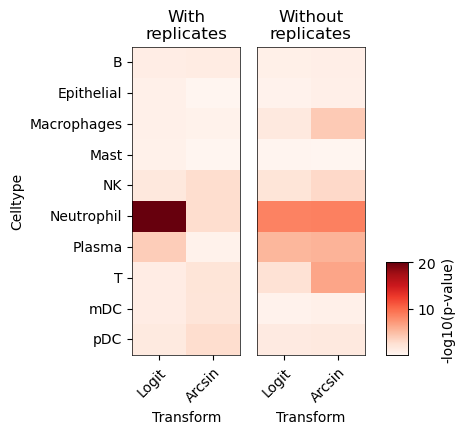

In [16]:
fig, axarr = plt.subplots(1,2, figsize=(3, 4))
plt.subplots_adjust(wspace=0.15)

#Create extra axes for colorbars
pvalue_cax = inset_axes(axarr[-1],
                        width="20%", height="30%",
                        loc='lower left',
                        bbox_to_anchor=(1.2, 0, 1, 1),
                        bbox_transform=axarr[-1].transAxes, borderpad=0)
pvalue_cax.set_frame_on(True)

vmax = value_table.max().max()

rep = value_table[["rep_logit", "rep_arcsin"]]
ax = sns.heatmap(rep , cmap="Reds", ax=axarr[0], cbar=False, vmax=vmax)
axarr[0].set_title("With\nreplicates")

norep = value_table[["norep_logit", "norep_arcsin"]]
ax = sns.heatmap(norep , cmap="Reds", ax=axarr[1], vmax=vmax, yticklabels=False, cbar_ax=pvalue_cax,
                 cbar_kws={"label": "-log10(p-value)"})
axarr[1].set_title("Without\nreplicates")

for ax in axarr:
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
    ax.set_xticks(ax.get_xticks(), ["Logit", "Arcsin"], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_xlabel("Transform")
    ax.set_ylabel("")
    
    # Drawing the frame
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
    
#Border around cbars
for cax in [pvalue_cax]:
    for _, spine in cax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

_ = axarr[0].set_ylabel("Celltype")


plt.savefig(f"{FIG_PATH}/covid_transform_comparison.pdf", bbox_inches="tight")